# Modelos para pronóstico de cuenta corriente (de series de tiempo y de ciencia de datos)

Debido a que los indicadores que componen la cuenta corriente se encuentran en constante revisión, las cuales pueden ser considerables, es necesario guardar las diferentes versiones con las que se corren los modelos para pronosticarla.

### Paso 1. Descargar la versión más reciente de la cuenta corriente de Banco de México

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
import os
import requests



token_1='82908162e488cf6a1e53620862cd2d9fa1181ba5a78882ffeb5d29320a19a145'

def descargar_banxico(serie,fecha_inicio,fecha_fin,token=token_1,es_oportuno=False):
    #Donde:
    # serie: el identificador o identificadores que tiene Banxico para cada serie de tiempo en su sistema de información
    #       las series se pueden consultar en la siguiente liga: https://www.banxico.org.mx/SieAPIRest/service/v1/doc/catalogoSeries
    # fecha_inicio: fecha aaaa-mm-dd en la que se quiere iniciar la consulta
    # fecha_fin: fecha aaaa-mm-dd en la que se quiere concluir la consulta
    # token: el token generado por la API de Banxico para acceder

    if es_oportuno==True:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/oportuno?token='+token
    else:
        url='https://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/'+fecha_inicio+'/'+fecha_fin+'?token='+token
    headers = {'Token':token}
    response = requests.get(url,headers=headers)
    status=response.status_code
    raw_data = response.json()
    T=len(serie.split(","))
    info={'fecha':pd.DataFrame(raw_data['bmx']['series'][0]['datos'])['fecha']}

    for i in range(T):
        titulo=raw_data['bmx']['series'][i]['titulo']

        data=raw_data['bmx']['series'][i]['datos']

        df=pd.DataFrame(data)
        df['dato'] = df['dato'].str.replace(',', '', regex=True).str.extract('(\d+\.\d+)')[0].astype(float)
        df['dato'] = df['dato'].apply(lambda x:float(x))
        info[titulo]=df['dato']
    info=pd.DataFrame(info)
    info.set_index('fecha',inplace=True)

    return info

In [3]:
fecha_inicio='2002-01-01'
fecha_fin='2023-07-01'

corr=descargar_banxico('SE44352',fecha_inicio,fecha_fin)
corr_credito=descargar_banxico('SE44353,SE44354,SE44357,SE44363,SE44369',fecha_inicio,fecha_fin)
corr_debito=descargar_banxico('SE44372,SE44373,SE44376,SE44382,SE44390',fecha_inicio,fecha_fin)
cap=descargar_banxico('SE44393,SE44394,SE44395',fecha_inicio,fecha_fin)

In [4]:
#para guardar las versiones de cuenta corriente
#df1=pd.DataFrame(pd.concat([corr,corr_credito,corr_debito,cap],axis=1))
#df1.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/balanza_pagos_230913.csv', index=True, header=True)

In [5]:
#función que acorta los títulos específicos de balanza de pagos

def limpiar_titulo(c_corr_credito):
    for k,v in c_corr_credito.items():
        nueva=k.split("(a partir de 2002)")[1]
        c_corr_credito[nueva]=c_corr_credito.pop(k)
    return c_corr_credito
corr_credito=limpiar_titulo(corr_credito)
corr_debito=limpiar_titulo(corr_debito)
corr=limpiar_titulo(corr)
cap=limpiar_titulo(cap)



In [6]:

#Cambiar nombres de columnas
corr.rename(columns={'Cuenta corriente (I - II)':'corr'},inplace=True)
corr_credito.rename(columns={'Cuenta corriente (I - II) I. Crédito (A + B + C + D) D. Ingreso secundario':'corr_cred_ingsec',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) C. Ingreso primario':'corr_cred_ingprim',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) B. Servicios 2/':'corr_cred_serv',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D) A. Bienes':'corr_cred_bien',
'Cuenta corriente (I - II) I. Crédito (A + B + C + D)':'corr_cred',},inplace=True)
cap.rename(columns={'Cuenta de capital (I - II) II. Débito':'cap_deb',
'Cuenta de capital (I - II) I.Crédito':'cap_cred',
'Cuenta de capital (I - II)':'cap',},inplace=True)
corr_debito.rename(columns={'Cuenta corriente (I - II) II. Débito (A + B + C + D) C. Ingreso primario':'corr_deb_ingprim',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) A. Bienes':'corr_deb_bien',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) B. Servicios 2/':'corr_deb_serv',
'Cuenta corriente (I - II) II. Débito (A + B + C + D) D. Ingreso secundario':'corr_deb_ingsec',
'Cuenta corriente (I - II) II. Débito (A + B + C + D)':'corr_deb_deb'},inplace=True)


## Análisis exploratorio de datos

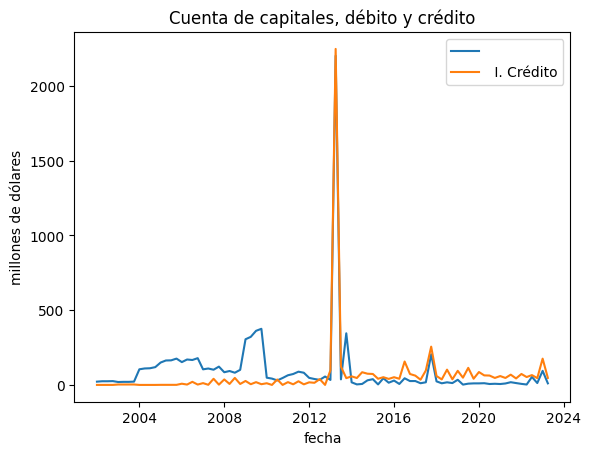

In [7]:
titulo3=[i.split('(I - II)', 1)[1] for i in cap.keys()]

x0=pd.to_datetime(list(cap.index),format="%d/%m/%Y")
y30=cap.iloc[:,1]
y31=cap.iloc[:,2]
plt.plot(x0,y30,x0,y31)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta de capitales, débito y crédito')

plt.savefig('CA_debitocredito.pdf', format="pdf", bbox_inches="tight")
plt.legend([titulo3[1],titulo3[2]])

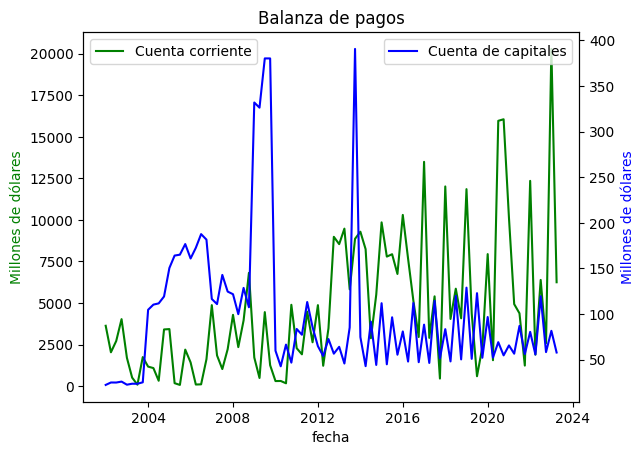

In [8]:
x0=pd.to_datetime(list(corr.index),format="%d/%m/%Y")
y00=corr.iloc[:,0]
y01=cap.iloc[:,0]

fig, ax0 = plt.subplots()

ax1 = ax0.twinx()
ax0.plot(x0, y00, 'g-')
ax1.plot(x0, y01, 'b-')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares', color='g')
ax1.set_ylabel('Millones de dólares', color='b')

plt.title('Balanza de pagos')
ax0.legend(['Cuenta corriente'])
ax1.legend(['Cuenta de capitales'])

plt.savefig('Balanza_pagos.pdf', format="pdf", bbox_inches="tight")
plt.show()

### Cuenta corriente. Crédito

Se observa que la cuenta de crédito de cuenta corriente más grande proviene de la cuenta de bienes, la cual comprenden exportaciones de mercancías y asciende a más de 175 mil millones de pesos. Por su parte, la segunda cuenta más grande (aunque considerablemente más chica que la cuenta de bienes) es la cuenta de ingresos secundarios, los cuales son casi su totalidad ingresos por remesas y ascienden a poco menos de 23 mil millones de pesos.

Por su parte, la cuenta de servicios primarios de crédito comprende utilidades, dividendos, intereses y remuneración de empleados, y ascendió a poco menos de 23 mil millones de pesos. Por otro lado, las de servicios suman transporte, viajes, servicios empresariales, propiedad intelectual entre los más importantes.

No obstante, en saldos netos (débito - crédito) la cuenta corriente de bienes, servicios e ingresos primarios se encuentra en saldos positivos, mientras que sólo la cuenta de ingresos secundarios se encuentra en saldos negativos. Por otro lado, se observa un poco de estacionalidad en las cuentas de ingresos primarios e ingresos secundarios.

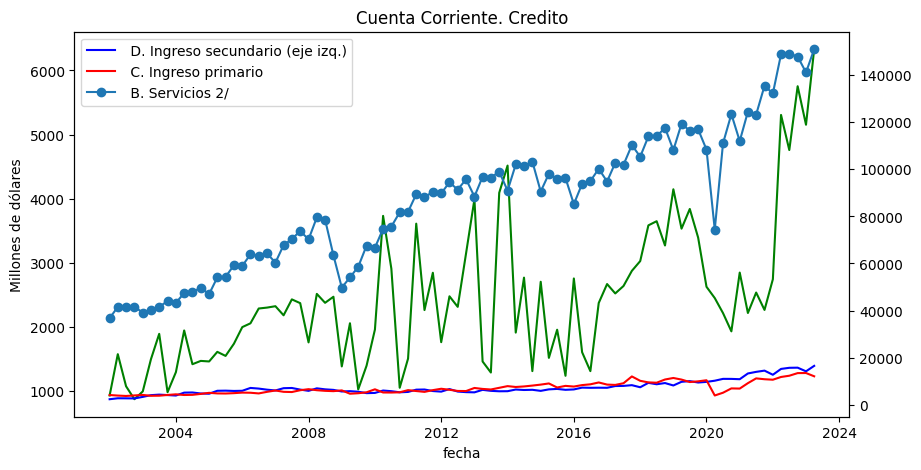

In [9]:
titulo1=[i.split('(A + B + C + D)', 1)[1] for i in corr_credito.keys()]

x1=pd.to_datetime(list(corr_credito.index),format="%d/%m/%Y")
y10=corr_credito.iloc[:,0]
y11=corr_credito.iloc[:,1]
y12=corr_credito.iloc[:,2]
y13=corr_credito.iloc[:,3]
y14=corr_credito.iloc[:,4]

fig, ax0 = plt.subplots(figsize=(10, 5))

ax1 = ax0.twinx()
ax0.plot(x1, y11, 'g-')
ax1.plot(x1, y10, 'b-')
ax1.plot(x1, y12, 'r-')
ax1.plot(x1, y13, 'o-')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares')
plt.title('Cuenta Corriente. Credito')
plt.legend([titulo1[0]+' (eje izq.)',titulo1[1],titulo1[2],titulo1[3]],loc='upper left')

plt.savefig('CC_credito.pdf', format="pdf", bbox_inches="tight")
plt.show()

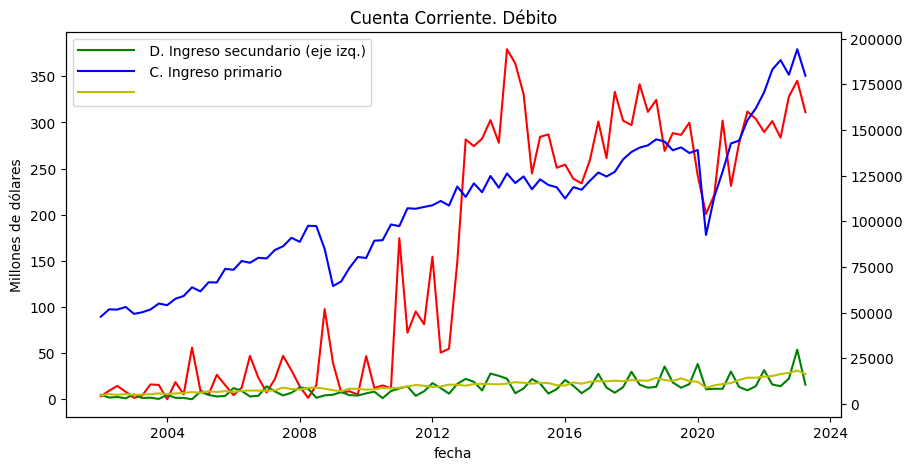

In [10]:

titulo2=[i.split('(A + B + C + D)', 1)[1] for i in corr_debito.keys()]

x2=pd.to_datetime(list(corr_debito.index),format="%d/%m/%Y")
y20=corr_debito.iloc[:,0]
y21=corr_debito.iloc[:,1]
y22=corr_debito.iloc[:,2]
y23=corr_debito.iloc[:,3]
y24=corr_debito.iloc[:,4]


fig, ax0 = plt.subplots(figsize=(10, 5))

ax1 = ax0.twinx()
ax0.plot(x1, y22,'r')
ax1.plot(x1, y20,'g')
ax1.plot(x1, y23,'b')
ax1.plot(x1, y24,'y')

ax0.set_xlabel('fecha')
ax0.set_ylabel('Millones de dólares')
plt.title('Cuenta Corriente. Débito')
plt.legend([titulo2[2]+' (eje izq.)',titulo2[0],titulo2[3],titulo2[4]],loc='upper left',handlelength=4)

plt.savefig('CC_debito.pdf', format="pdf", bbox_inches="tight")

plt.show()

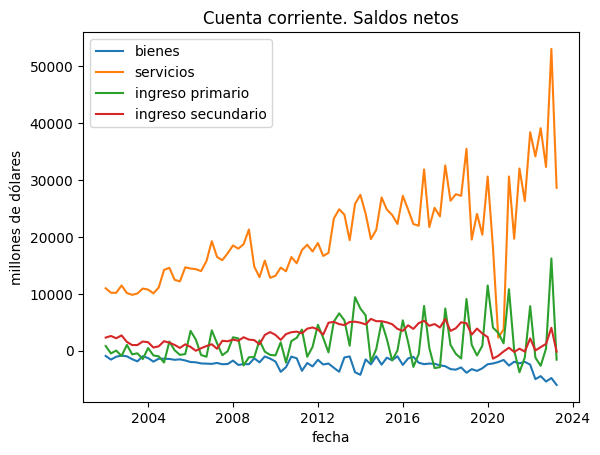

In [11]:
corr_neto_ingsec=corr_debito.iloc[:,4]-corr_credito.iloc[:,0]
corr_neto_serv=corr_debito.iloc[:,3]-corr_credito.iloc[:,3]
corr_neto_ingprim=corr_debito.iloc[:,0]-corr_credito.iloc[:,2]
corr_neto_bienes=corr_debito.iloc[:,2]-corr_credito.iloc[:,1]
plt.plot(x2,corr_neto_bienes,x2,corr_neto_serv,x2,corr_neto_ingprim,x2,corr_neto_ingsec)
plt.xlabel('fecha')
plt.ylabel('millones de dólares')
plt.title('Cuenta corriente. Saldos netos')
plt.legend(['bienes','servicios','ingreso primario','ingreso secundario'])

plt.savefig('CC_saldosnetos.pdf', format="pdf", bbox_inches="tight")


### 2. Selección de variables explicativas

Dado que en la cuenta de crédito los bienes fueron la subcuenta más grande con 178 mil millones de dólares, se revisó el análisis de exportaciones e importaciones del [atlas de Harvard](https://atlas.cid.harvard.edu/countries/138/export-basket) para México. De acuerdo con dicha base de datos, las principales *exportaciones netas* para México en 2021 fueron en autos y autopartes (~28%), computadoras (~14%), petróleo (~8.3%), otros minerales (~8.5%), así como alimentos, bebidas y agropecuarios (~8%), entre otros. Por ello, se incluyó en el modelo la producción industrial de estos componentes.

Por otro lado, las cuentas de ingresos secundarios  también incluyen los ingresos por remesas, así como para la cuenta de servicios se incluyeron turismo, propiedad intelectual, que son los principales componentes.

Por todo lo anterior, se incluyeron en el modelo las siguientes variables:

* IGAE base 2013, serie original, mensual, publicada por INEGI.
* Ingresos por remesas en millones de dólares, mensual, publicada por Banco de México.
* Tipo de cambio peso-dólar promedio FIX mensual, publicada por banco de México.
* Indice de volumen de la inversión fija bruta,
* INPC general

cuadro de pronóstico de los tres meses del 2023, evaluar RMSE u otros para sep, oct, nov, dic
cuadro los criterios para evaluar

no borrar los códigos de las demás

meter las redes neuronales


Destacan las siguientes características:

1. Debido a que algunas variables están en dólares y otras en pesos, se usa como control el tipo de cambio FIX promedio del periodo
2. Se decidió descargar las series originales para aplicar luego su propio proceso de desestacionalización
3. Dado que las series de balanza de pagos son trimestrales y las variables explicativas son mensuales, se realizó un nowcasting de las series de balanza de pagos

Se plantearon tres posibles modelos de predicción para cuenta corriente:

* con modelos autorregresivos tradicionales
* con modelos de redes neuronales
* con modelos de inferencia bayesianos

### 4. Modelos de predicción para cuenta corriente considerados

#### 4.1. Modelo autoarima

In [12]:

igae=descargar_banxico('SR16734',fecha_inicio,fecha_fin)
remesas=descargar_banxico('SE27803',fecha_inicio,fecha_fin)
usdmxn_mensual=descargar_banxico('SF17908',fecha_inicio,fecha_fin)
usdmxn_diaria=descargar_banxico('SF43718',fecha_inicio,fecha_fin)
ifb=descargar_banxico('SR17459',fecha_inicio,fecha_fin)
inpc=descargar_banxico('SP1',fecha_inicio,fecha_fin)

In [13]:
#train_set1=explicativas.iloc[:-2,:]
explicativas=pd.concat([igae,remesas,usdmxn_mensual,ifb,inpc],axis=1)
explicativas=pd.concat([explicativas,corr],axis=1).ffill().set_index(pd.to_datetime(list(explicativas.index),format="%d/%m/%Y"))
explicativas1=explicativas.apply(lambda x:np.log(x))
train_set1, test_set1= np.split(explicativas1, [int(.9 *len(explicativas1))])

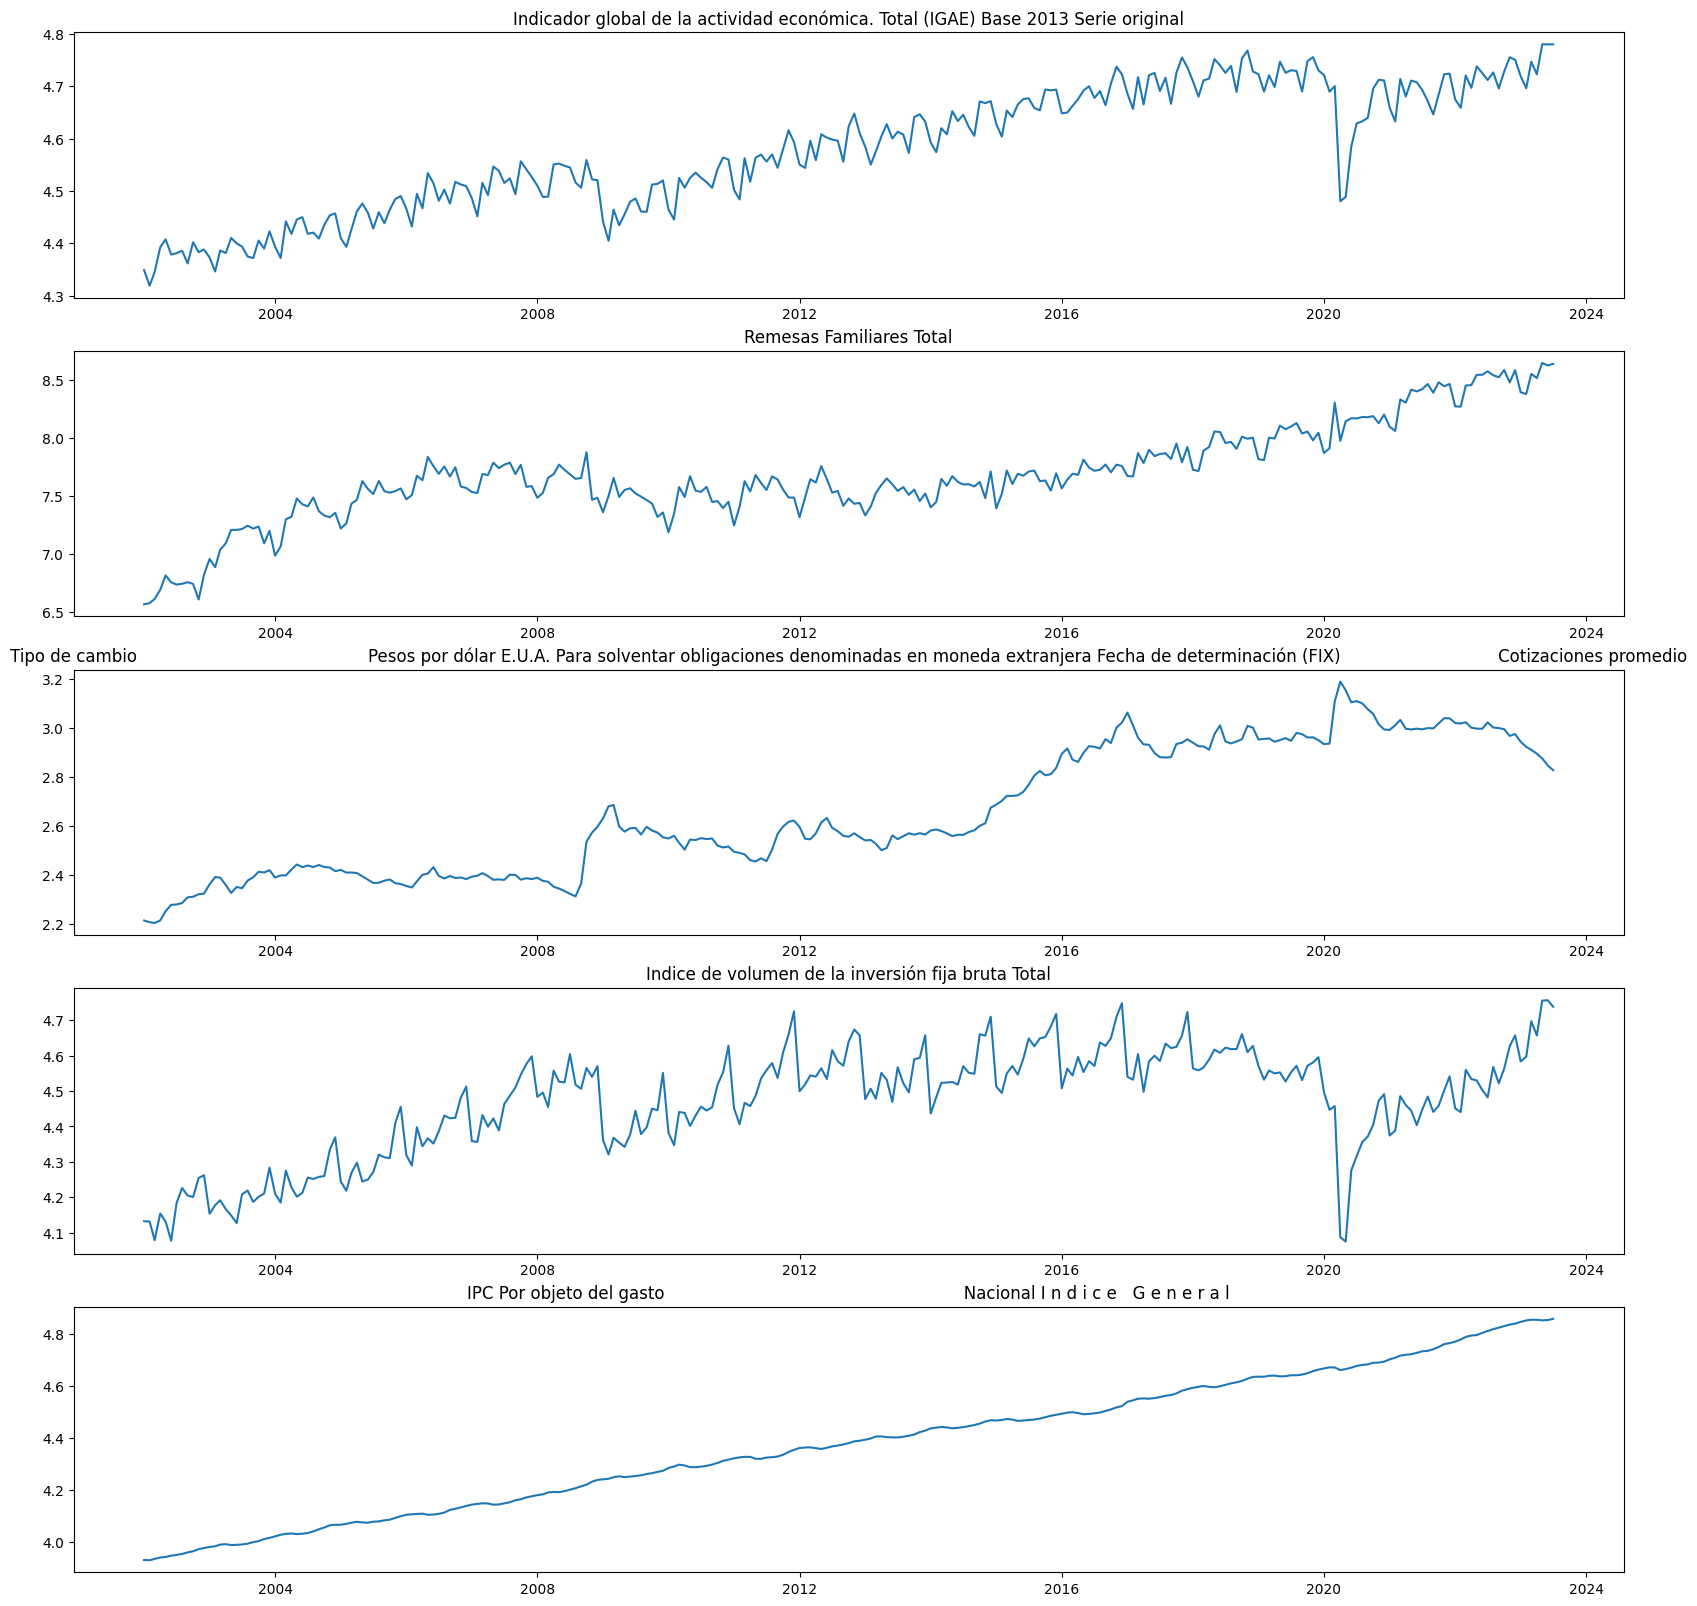

In [14]:
x=pd.to_datetime(list(explicativas.index),format="%Y/%m/%d")

fig, axs = plt.subplots(5,1, figsize=(20, 20), sharey=False)

for j in range(5):
    axs[j].plot(x,explicativas1.iloc[:,j])
    axs[j].set_title(explicativas1.columns[j])

plt.show()

In [15]:
#guardar la versión de nowcast
#df2=pd.DataFrame(pd.concat([explicativas,corr], axis=1))
#df2.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/nowcast_bp_230918.csv', index=True, header=True)

### Modelos auto-arima para explicativas

In [16]:
!pip install pmdarima
#!pip install torch
import pmdarima

#auto_arimas_conexp=train_set1.apply(lambda x:pmdarima.arima.auto_arima(x,X=train_set1.drop(x),error_action='ignore', trace=True,suppress_warnings=True, maxiter=5,seasonal=True, m=12))
auto_arimas_sinexp=[]
auto_arimas_conexp=[]
T1=explicativas1.shape[1]

for i in range(T1):
    yest=train_set1.iloc[:,i]
    xest=train_set1.drop(train_set1.columns[i],axis=1)
    auto_arimas_sinexp.append(pmdarima.arima.auto_arima(yest,error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))
    auto_arimas_conexp.append(pmdarima.arima.auto_arima(yest,xest,error_action='ignore',suppress_warnings=True, maxiter=10,with_intercept=True,seasonal=True, m=12))
    #results.append({'variable':[explicativas.columns.values[i]],'params':[auto_arimas[i].params()],'pvalues':[auto_arimas[i].pvalues()]},ignore_index=True)

['auto arimas sin variables explicativas',auto_arimas_sinexp,
'auto arimas sin variables explicativas',auto_arimas_conexp]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.8 MB/s eta 0:00:00


['auto arimas sin variables explicativas',
 [ARIMA(maxiter=10, order=(0, 1, 2), scoring_args={},
        seasonal_order=(1, 0, 1, 12), suppress_warnings=True,
        with_intercept=False),
  ARIMA(maxiter=10, order=(2, 1, 2), scoring_args={},
        seasonal_order=(1, 0, 1, 12), suppress_warnings=True),
  ARIMA(maxiter=10, order=(0, 1, 1), scoring_args={},
        seasonal_order=(0, 0, 0, 12), suppress_warnings=True,
        with_intercept=False),
  ARIMA(maxiter=10, order=(0, 1, 2), scoring_args={},
        seasonal_order=(1, 0, 1, 12), suppress_warnings=True,
        with_intercept=False),
  ARIMA(maxiter=10, order=(2, 1, 0), scoring_args={},
        seasonal_order=(1, 0, 1, 12), suppress_warnings=True),
  ARIMA(maxiter=10, order=(0, 1, 0), scoring_args={},
        seasonal_order=(1, 0, 1, 12), suppress_warnings=True,
        with_intercept=False)],
 'auto arimas sin variables explicativas',
 [ARIMA(maxiter=10, order=(0, 1, 2), scoring_args={},
        seasonal_order=(1, 0, 1, 12),

In [17]:

def predicciones_calculo(auto_arimas,num_periodos,Xest=None):
    T1=np.shape(explicativas)[1]
    forward_sinexp=pd.DataFrame({})
    for i in range(T1):
        forward_sinexp=pd.concat([forward_sinexp,auto_arimas[i].predict(len(test_set1)+num_periodos,Xest)],axis=1)
    forward_sinexp=forward_sinexp.set_axis([train_set1.columns.values], axis='columns').set_index(pd.date_range(test_set1.index[0],periods=len(test_set1)+num_periodos,freq='m'))
    return forward_sinexp

predicciones_sinexp=predicciones_calculo(auto_arimas_sinexp,18)
predicciones_sinexp.tail()

,Indicador global de la actividad económica. Total (IGAE) Base 2013 Serie original,Remesas Familiares Total,Tipo de cambio Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX) Cotizaciones promedio,Indice de volumen de la inversión fija bruta Total,IPC Por objeto del gasto Nacional I n d i c e G e n e r a l,Cuenta corriente (I - II)
2024-09-30,4.728431,8.894266,2.997767,4.526239,4.864883,9.132986
2024-10-31,4.764058,8.914634,2.997767,4.545522,4.869712,9.168495
2024-11-30,4.773607,8.889807,2.997767,4.562034,4.874807,9.168495
2024-12-31,4.763808,8.930184,2.997767,4.575631,4.879265,9.168495
2025-01-31,4.744406,8.868662,2.997767,4.509523,4.884397,9.335338


### Predicciones de modelos sin regresores

In [18]:

#estimadores=pd.DataFrame(auto_arimas).apply(lambda x:x.params())
#estimadores
results=pd.DataFrame({})
for num_var in range(4):
    #results.append({'params':[auto_arimas[i].params()],'pvalues':[auto_arimas[i].pvalues()]},ignore_index=True)
    A=pd.concat({explicativas.columns.values[num_var]:pd.concat([round(auto_arimas_sinexp[num_var].params(),2),round(auto_arimas_sinexp[num_var].pvalues(),3)],keys=['params','pvalues'],axis=1)})
    results=pd.concat([results,A])

results


params  pvalues
Indicador global de la actividad económica. Tot... ma.L1       -0.24    0.000
                                                   ma.L2       -0.25    0.000
                                                   ar.S.L12     0.93    0.000
                                                   ma.S.L12    -0.67    0.000
                                                   sigma2       0.00    0.000
Remesas Familiares Total                           intercept    0.00    0.168
                                                   ar.L1       -0.81    0.001
                                                   ar.L2       -0.16    0.302
                                                   ma.L1        0.32    0.192
                                                   ma.L2       -0.31    0.144
                                                   ar.S.L12     0.87    0.000
                                                   ma.S.L12    -0.45    0.000
                                                   sigma2       0.00    0.000
Tipo de cambio                                 ... ma.L1        0.34    0.000
                                                   sigma2       0.00    0.000
Indice de volumen de la inversión fija bruta Total ma.L1       -0.25    0.000
                                                   ma.L2       -0.15    0.003
                                                   ar.S.L12     0.90    0.000
                                                   ma.S.L12    -0.60    0.000
                                                   sigma2       0.00    0.000

In [19]:
predicciones_conexp=predicciones_calculo(auto_arimas_sinexp,18,predicciones_sinexp)
predicciones_conexp.tail()

,Indicador global de la actividad económica. Total (IGAE) Base 2013 Serie original,Remesas Familiares Total,Tipo de cambio Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX) Cotizaciones promedio,Indice de volumen de la inversión fija bruta Total,IPC Por objeto del gasto Nacional I n d i c e G e n e r a l,Cuenta corriente (I - II)
2024-09-30,4.728431,8.894266,2.997767,4.526239,4.864883,9.132986
2024-10-31,4.764058,8.914634,2.997767,4.545522,4.869712,9.168495
2024-11-30,4.773607,8.889807,2.997767,4.562034,4.874807,9.168495
2024-12-31,4.763808,8.930184,2.997767,4.575631,4.879265,9.168495
2025-01-31,4.744406,8.868662,2.997767,4.509523,4.884397,9.335338


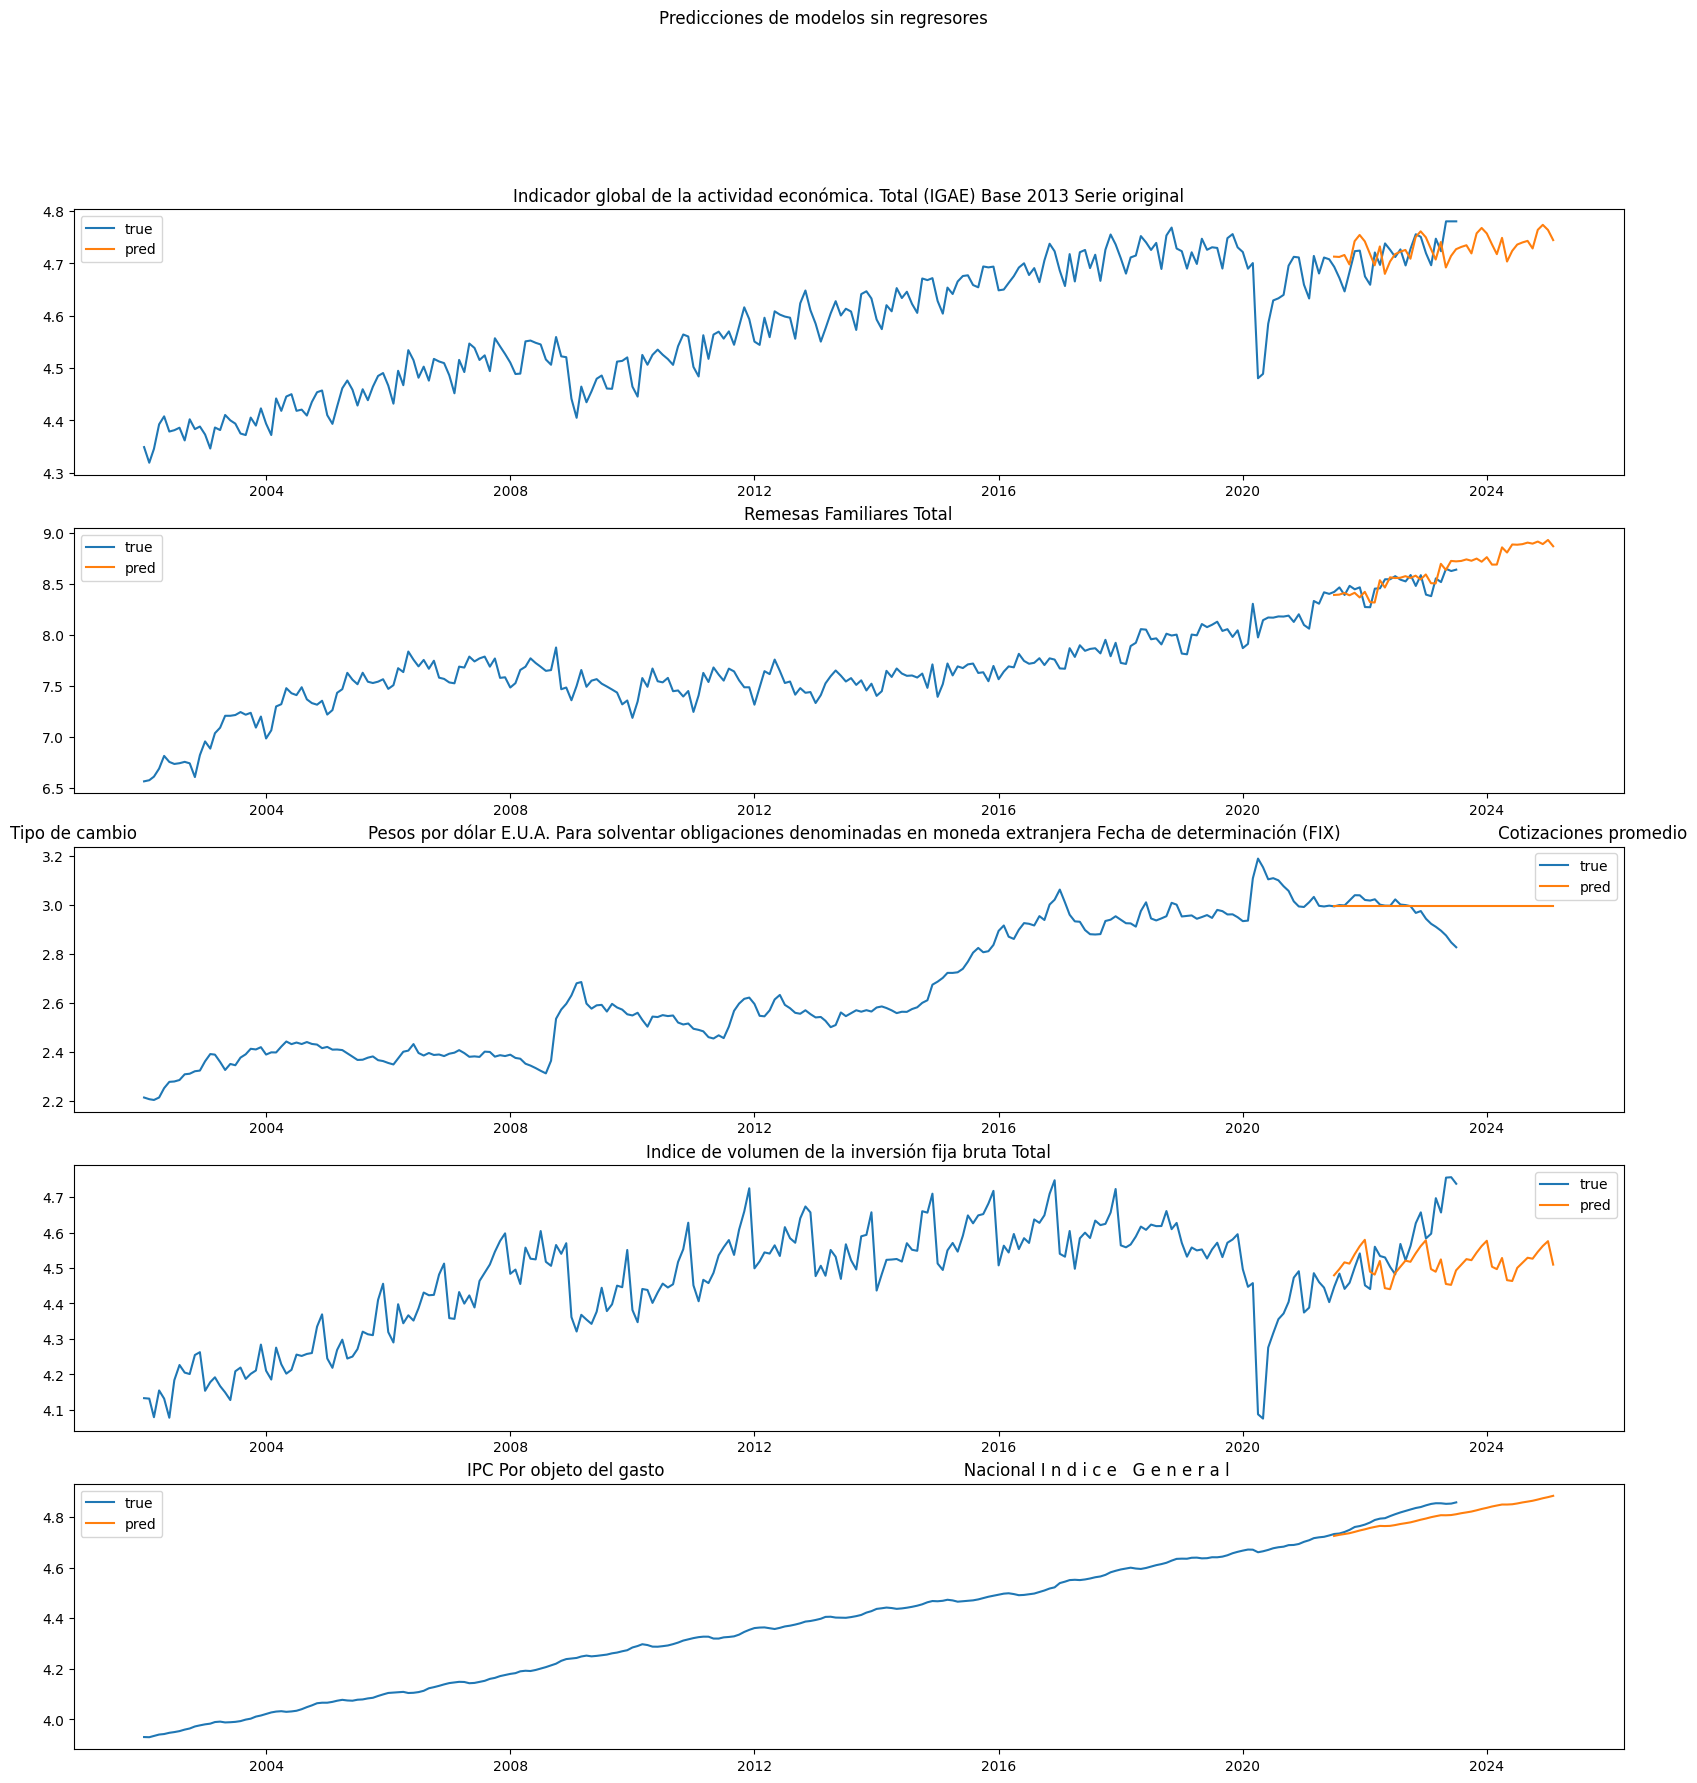

[['Indicador global de la actividad económica. Total (IGAE)\xa0Base 2013 Serie original',
  ('Indicador global de la actividad económica. Total (IGAE)\xa0Base 2013 Serie original',)],
 ['Remesas Familiares Total', ('Remesas Familiares Total',)],
 ['Tipo de cambio                                            Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX)                              Cotizaciones promedio',
  ('Tipo de cambio                                            Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX)                              Cotizaciones promedio',)],
 ['Indice de volumen de la inversión fija bruta Total',
  ('Indice de volumen de la inversión fija bruta Total',)],
 ['IPC Por objeto del gasto                                                         Nacional I n d i c e   G e n e r a l',
  ('IPC Por objeto del gasto                             

<Figure size 640x480 with 0 Axes>

In [20]:
fig, axs = plt.subplots(5,1, figsize=(20, 20), sharey=False)
xk=predicciones_sinexp.index
check0=[]
for j in range(5):
    axs[j].plot(x,explicativas1.iloc[:,j],xk,predicciones_sinexp.iloc[:,j])
    axs[j].legend(['true','pred'])
    axs[j].set_title(explicativas1.columns[j])
    check0.append([explicativas1.columns[j],predicciones_sinexp.columns[j]])
fig.suptitle('Predicciones de modelos sin regresores')
plt.show()

plt.savefig('modelos_ARIMA.pdf', format="pdf", bbox_inches="tight")
check0

In [21]:
#predicciones_sinexp.to_csv('/Users/1thaliaespana1/Documents/Semestre II/ambientes/sandbox_Python/estancia_investigacion/modelacion_economica/versiones_balanza_pagos/predicciones_autoarima_230926.csv', index=True, header=True)

### Predicciones de modelos con regresores

In [22]:

#estimadores=pd.DataFrame(auto_arimas).apply(lambda x:x.params())
#estimadores
results=pd.DataFrame({})
for num_var in range(1,6):
    #results.append({'params':[auto_arimas[i].params()],'pvalues':[auto_arimas[i].pvalues()]},ignore_index=True)
    A=pd.concat({explicativas1.columns.values[num_var]:pd.concat([round(auto_arimas_conexp[num_var].params(),2),round(auto_arimas_conexp[num_var].pvalues(),3)],keys=['params','pvalues'],axis=1)})
    results=pd.concat([results,A])

results


params  \
Remesas Familiares Total                           intercept                                            -0.06   
                                                   Indicador global de la actividad económica. Tot...    1.10   
                                                   Tipo de cambio                                 ...    0.29   
                                                   Indice de volumen de la inversión fija bruta Total   -0.07   
                                                   IPC Por objeto del gasto                       ...    0.94   
                                                    Cuenta corriente (I - II)                           -0.01   
                                                   ar.L1                                                 0.18   
                                                   ar.L2                                                 0.68   
                                                   ma.L1                                                 0.36   
                                                   ma.L2                                                -0.27   
                                                   ma.L3                                                 0.04   
                                                   ar.S.L12                                              0.48   
                                                   ar.S.L24                                              0.30   
                                                   sigma2                                                0.00   
Tipo de cambio                                 ... intercept                                            -0.12   
                                                   Indicador global de la actividad económica. Tot...   -0.26   
                                                   Remesas Familiares Total                              0.20   
                                                   Indice de volumen de la inversión fija bruta Total   -0.23   
                                                   IPC Por objeto del gasto                       ...    1.26   
                                                    Cuenta corriente (I - II)                           -0.00   
                                                   ar.L1                                                 0.89   
                                                   ar.S.L12                                              0.48   
                                                   sigma2                                                0.00   
Indice de volumen de la inversión fija bruta Total intercept                                            -0.00   
                                                   Indicador global de la actividad económica. Tot...    1.45   
                                                   Remesas Familiares Total                             -0.00   
                                                   Tipo de cambio                                 ...   -0.04   
                                                   IPC Por objeto del gasto                       ...    0.77   
                                                    Cuenta corriente (I - II)                            0.00   
                                                   ar.L1                                                -0.48   
                                                   ar.L2                                                -0.25   
                                                   ar.S.L12                                              0.62   
                                                   ar.S.L24                                              0.21   
                                                   sigma2                                                0.00   
IPC Por objeto del gasto                       ... intercept                                             0.00   
                                   

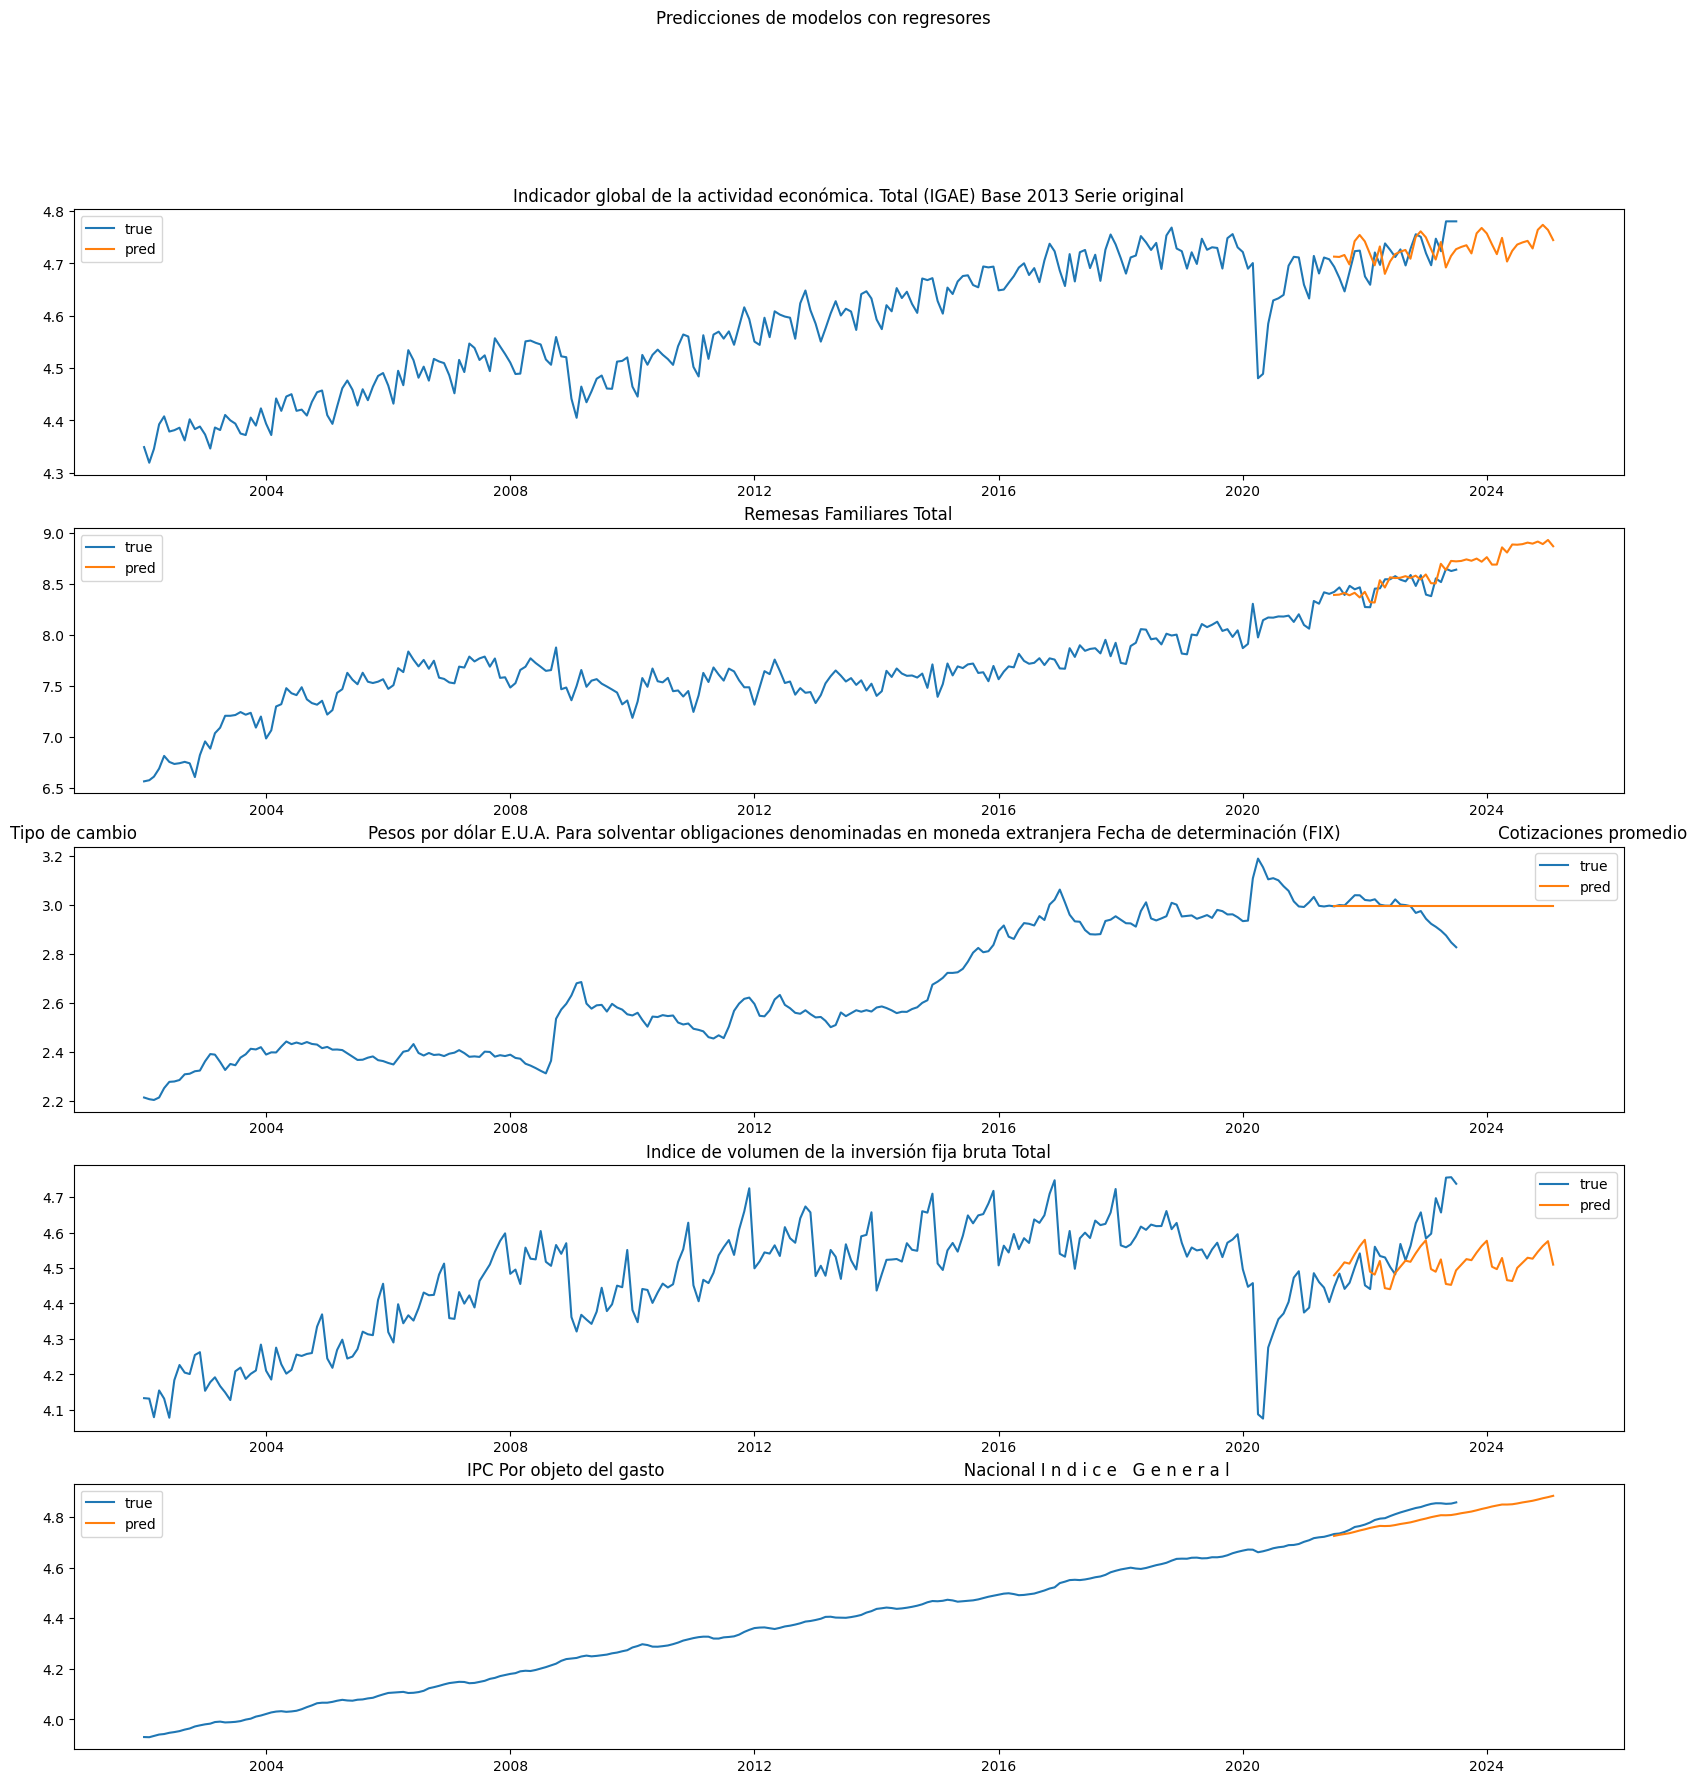

[['Indicador global de la actividad económica. Total (IGAE)\xa0Base 2013 Serie original',
  ('Indicador global de la actividad económica. Total (IGAE)\xa0Base 2013 Serie original',)],
 ['Remesas Familiares Total', ('Remesas Familiares Total',)],
 ['Tipo de cambio                                            Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX)                              Cotizaciones promedio',
  ('Tipo de cambio                                            Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX)                              Cotizaciones promedio',)],
 ['Indice de volumen de la inversión fija bruta Total',
  ('Indice de volumen de la inversión fija bruta Total',)],
 ['IPC Por objeto del gasto                                                         Nacional I n d i c e   G e n e r a l',
  ('IPC Por objeto del gasto                             

In [23]:
fig, axs = plt.subplots(5,1, figsize=(20, 20), sharey=False)
xk=predicciones_conexp.index
check1=[]
for j in range(5):
    axs[j].plot(x,explicativas1.iloc[:,j],xk,predicciones_conexp.iloc[:,j])
    axs[j].legend(['true','pred'])
    axs[j].set_title(explicativas1.columns[j])
    check1.append([explicativas1.columns[j],predicciones_conexp.columns[j]])
fig.suptitle('Predicciones de modelos con regresores')
plt.show()
check1

### Resultados RMSE

In [24]:
import math
from sklearn.metrics import mean_squared_error

RMSE=[]
final={}
for i in range(6):
    RMSE.append([explicativas1.columns[i],
                 round(math.sqrt(mean_squared_error(test_set1.iloc[:-2,i],predicciones_conexp.iloc[:-20,i])),3)])
    final.update({explicativas1.columns[i]:
                 round(math.sqrt(mean_squared_error(test_set1.iloc[:-2,i],predicciones_conexp.iloc[:-20,i])),3)})
RMSE01=pd.DataFrame(RMSE).set_axis(['variable','RMSE'], axis='columns')
RMSE01


,variable,RMSE
0,Indicador global de la actividad económica. To...,0.029
1,Remesas Familiares Total,0.066
2,Tipo de cambio ...,0.045
3,Indice de volumen de la inversión fija bruta T...,0.100
4,IPC Por objeto del gasto ...,0.034
5,Cuenta corriente (I - II),0.924


### 3. Explicación de modelos autoarima, redes neuronales, crossval, inferencia bayesiana (quizá gridsearch)
Justificar selección de parámetros

In [25]:
#from nowcast_lstm.LSTM import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(explicativas1, train_size=0.85, test_size=0.15, shuffle=False)

#model=LSTM(df_train, target_variable="Cuenta corriente (I - II)", n_timesteps=10,fill_ragged_edges_func="ARMA")
#model.train()

#### 4.2. Modelo de redes neuronales

In [26]:
def build_dataset(X,Y, hist_size):
  '''
  Params
    X: data matrix [n_time_steps, n_X_feats]
    Y: label matrix [n_time_steps, n_Y_feats]
    hist_size: integer indicating the number of time steps in each sample of x
  Returns
    x: tensor of input data [n_samples, n_timesteps, n_X_features]
    y: tensor of output data [n_samples, n_Y_features]
  '''
  n_samples = Y.shape[0] - hist_size
  x = np.zeros((n_samples, hist_size, X.shape[1]))
  y = np.zeros((n_samples))

  min_max_scaler = MinMaxScaler()
  X = min_max_scaler.fit_transform(X.values)

  for ind in range(n_samples):
    x[ind] = X[ind : ind + hist_size]
    y[ind] = Y[ind + hist_size]
  return x, y
def x_y_split(df):
  ytrain=df.iloc[:,5]
  xtrain=df.drop(df.columns[5],axis=1)
  return xtrain,ytrain

x_train,y_train=x_y_split(df_train)
x_test,y_test=x_y_split(df_test)
x_train,y_train=build_dataset(x_train,y_train,4)
x_test,y_test=build_dataset(x_test,y_test,4)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(216, 4, 5)
(35, 4, 5)
(216,)
(35,)


In [27]:
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Input, Dropout, SimpleRNN, Dense, LeakyReLU
  from tensorflow.keras.utils import plot_model

  # Create RNN model
rnn_model = Sequential()
rnn_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
rnn_model.add(SimpleRNN(units=32))
rnn_model.add(Dense(128, activation='sigmoid'))
rnn_model.add(Dense(128, activation='sigmoid'))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dense(1, activation='linear'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 30273 (118.25 KB)
Trainable params: 30273 (118.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
rnn_model.compile(loss='mean_squared_error', optimizer='rmsprop')
history = rnn_model.fit(x_train, y_train, epochs=120, batch_size=6, validation_split=0.1)

Epoch 1/120
33/33 [==============================] - 2s 21ms/step - loss: 13.7198 - val_loss: 0.8801
Epoch 2/120
33/33 [==============================] - 0s 4ms/step - loss: 1.7643 - val_loss: 0.9163
Epoch 3/120
33/33 [==============================] - 0s 5ms/step - loss: 1.7497 - val_loss: 2.0240
Epoch 4/120
33/33 [==============================] - 0s 5ms/step - loss: 1.5441 - val_loss: 1.0118
Epoch 5/120
33/33 [==============================] - 0s 5ms/step - loss: 1.2997 - val_loss: 0.7321
Epoch 6/120
33/33 [==============================] - 0s 7ms/step - loss: 1.1884 - val_loss: 0.6896
Epoch 7/120
33/33 [==============================] - 0s 6ms/step - loss: 1.1605 - val_loss: 1.0435
Epoch 8/120
33/33 [==============================] - 0s 4ms/step - loss: 1.1127 - val_loss: 0.9422
Epoch 9/120
33/33 [==============================] - 0s 5ms/step - loss: 1.1352 - val_loss: 0.6892
Epoch 10/120
33/33 [==============================] - 0s 5ms/step - loss: 1.1156 - val_loss: 0.7343
Epoch 1

2/2 [==============================] - 0s 6ms/step
(216, 1) (35, 1)


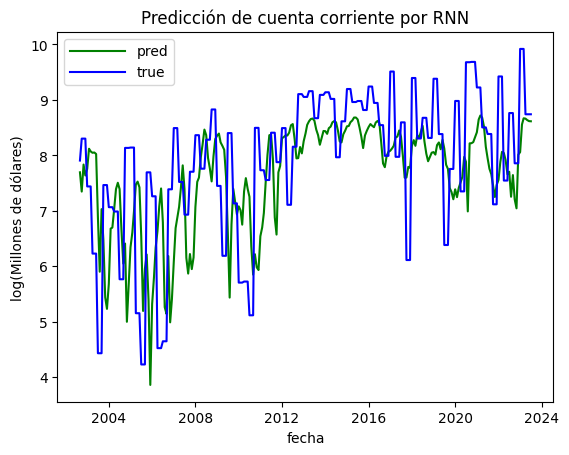

In [41]:
y_train_hat = rnn_model.predict(x_train)
y_test_hat = rnn_model.predict(x_test)
y_train_hat=pd.DataFrame(y_train_hat).set_index(pd.to_datetime(list(explicativas1.index[:len(y_train_hat)]),format="%Y/%m/%d"))
y_test_hat=pd.DataFrame(y_test_hat).set_index(pd.to_datetime(list(explicativas1.index[-35:]),format="%Y/%m/%d"))
print(y_train_hat.shape,y_test_hat.shape)

xnn=pd.to_datetime(list(explicativas1.index[8:]),format="%Y/%m/%d")
ytrue=explicativas1.iloc[8:,5]
ypred=pd.concat([y_train_hat,y_test_hat])
fig, ax0 = plt.subplots()

ax0.plot(xnn, ypred, 'g-')
ax0.plot(xnn, ytrue, 'b-')
ax0.set_xlabel('fecha')
ax0.set_ylabel('log(Millones de dólares)')
plt.title('Predicción de cuenta corriente por RNN')
plt.legend(['pred','true'],loc='upper left',handlelength=4)

plt.savefig("modelo_RNN.pdf", format="pdf", bbox_inches="tight")

### LSTM

In [30]:
from tensorflow.keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(Input(shape=(x_train.shape[1], x_train.shape[2])))
lstm_model.add(LSTM(units=32))
lstm_model.add(Dense(64, activation='sigmoid'))
lstm_model.add(Dense(128, activation='sigmoid'))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(LeakyReLU())
lstm_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 30273 (118.25 KB)
Trainable params: 30273 (118.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop')
history1 = lstm_model.fit(x_train, y_train, epochs=120, batch_size=2, validation_split=0.1)

Epoch 1/120
97/97 [==============================] - 2s 8ms/step - loss: 4.5567 - val_loss: 1.1025
Epoch 2/120
97/97 [==============================] - 0s 2ms/step - loss: 1.7958 - val_loss: 1.0088
Epoch 3/120
97/97 [==============================] - 0s 2ms/step - loss: 1.6802 - val_loss: 0.9541
Epoch 4/120
97/97 [==============================] - 0s 2ms/step - loss: 1.5425 - val_loss: 1.0094
Epoch 5/120
97/97 [==============================] - 0s 2ms/step - loss: 1.4845 - val_loss: 1.0294
Epoch 6/120
97/97 [==============================] - 0s 3ms/step - loss: 1.4481 - val_loss: 0.8526
Epoch 7/120
97/97 [==============================] - 0s 3ms/step - loss: 1.4322 - val_loss: 0.9772
Epoch 8/120
97/97 [==============================] - 0s 3ms/step - loss: 1.3357 - val_loss: 0.8151
Epoch 9/120
97/97 [==============================] - 0s 2ms/step - loss: 1.3566 - val_loss: 1.9257
Epoch 10/120
97/97 [==============================] - 0s 2ms/step - loss: 1.3235 - val_loss: 1.9344
Epoch 11/

2/2 [==============================] - 0s 4ms/step
(216, 1) (35, 1)


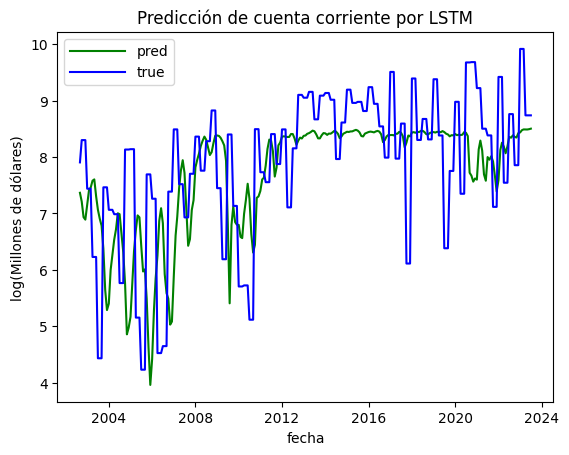

In [40]:
y_train_hat_lstm = lstm_model.predict(x_train)
y_test_hat_lstm = lstm_model.predict(x_test)
y_train_hat_lstm=pd.DataFrame(y_train_hat_lstm).set_index(pd.to_datetime(list(explicativas1.index[:len(y_train_hat)]),format="%Y/%m/%d"))
y_test_hat_lstm=pd.DataFrame(y_test_hat_lstm).set_index(pd.to_datetime(list(explicativas1.index[-35:]),format="%Y/%m/%d"))
print(y_train_hat_lstm.shape,y_test_hat_lstm.shape)

xnn=pd.to_datetime(list(explicativas1.index[8:]),format="%Y/%m/%d")
ypred_lstm=pd.concat([y_train_hat_lstm,y_test_hat_lstm])

fig, ax0 = plt.subplots()

ax0.plot(xnn, ypred_lstm, 'g-')
ax0.plot(xnn, ytrue, 'b-')
ax0.set_xlabel('fecha')
ax0.set_ylabel('log(Millones de dólares)')
plt.title('Predicción de cuenta corriente por LSTM')
plt.legend(['pred','true'],loc='upper left',handlelength=4)

plt.savefig("modelo_LSTM.pdf", format="pdf", bbox_inches="tight")

### Comparación entre los dos modelos de aprendizaje profundo (LSTM y RNN)

In [33]:
from sklearn.metrics import mean_squared_error
RMSE_RNN=round(np.sqrt(mean_squared_error(ytrue,ypred)),3)
RMSE_LSTM=round(np.sqrt(mean_squared_error(ytrue,ypred_lstm)),3)
print('RMSE RNN: ',RMSE_RNN)
print('RMSE LSTM: ',RMSE_LSTM)


RMSE RNN:  1.209
RMSE LSTM:  1.215


### 5. Conclusiones

cuadros con pronósticos mes a mes, RMSE de muestra y pronósticos de un año fuera de muestra para todos

gráficas monas

enseñarle a un chavo 3 zooms, básico de cómo ejecutarlo, dónde se genera la red neuronal, dónde se genera el auto arima
en una forma didáctica de hacerlo (colab google y anaconda)


In [34]:
X_predict,yyy=build_dataset(predicciones_conexp.iloc[:,0:5],predicciones_conexp.iloc[:,5],4)
rnn_predic=pd.DataFrame(rnn_model.predict(X_predict)).set_index([predicciones_conexp.index[4:]]).set_axis(['RNN cuenta corriente'], axis='columns')
lstm_predic=pd.DataFrame(lstm_model.predict(X_predict)).set_index([predicciones_conexp.index[4:]]).set_axis(['LSTM cuenta corriente'], axis='columns')

2/2 [==============================] - 0s 5ms/step


In [35]:

predicciones=pd.concat([predicciones_conexp,rnn_predic,lstm_predic],axis=1).apply(lambda x:np.exp(x))
predicciones.tail()

,"(Indicador global de la actividad económica. Total (IGAE) Base 2013 Serie original,)","(Remesas Familiares Total,)","(Tipo de cambio Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX) Cotizaciones promedio,)","(Indice de volumen de la inversión fija bruta Total,)","(IPC Por objeto del gasto Nacional I n d i c e G e n e r a l,)","( Cuenta corriente (I - II),)",RNN cuenta corriente,LSTM cuenta corriente
2024-09-30,113.117973,7290.053973,20.040742,92.410312,129.655722,9255.621424,329.586945,1443.506958
2024-10-31,117.220598,7440.055410,20.040742,94.209577,130.283441,9590.184287,1078.216187,4371.327637
2024-11-30,118.345325,7257.617708,20.040742,95.778093,130.948905,9590.184287,1994.809448,4656.979004
2024-12-31,117.191375,7556.658503,20.040742,97.089311,131.533970,9590.184287,3354.206543,4799.961426
2025-01-31,114.939456,7105.767230,20.040742,90.878459,132.210736,11331.454014,4025.957520,4895.084961


In [36]:
RMSES=list(RMSE01['RMSE'])
predicciones.loc[len(predicciones.index)] = RMSES+[RMSE_RNN]+[RMSE_LSTM]

In [37]:
exportar_cuadro=pd.concat([predicciones.iloc[-1:], predicciones.iloc[:-1]], axis=0).rename(index={44:'RMSE'})
exportar_cuadro

,"(Indicador global de la actividad económica. Total (IGAE) Base 2013 Serie original,)","(Remesas Familiares Total,)","(Tipo de cambio Pesos por dólar E.U.A. Para solventar obligaciones denominadas en moneda extranjera Fecha de determinación (FIX) Cotizaciones promedio,)","(Indice de volumen de la inversión fija bruta Total,)","(IPC Por objeto del gasto Nacional I n d i c e G e n e r a l,)","( Cuenta corriente (I - II),)",RNN cuenta corriente,LSTM cuenta corriente
RMSE,0.029000,0.066000,0.045000,0.100000,0.034000,0.924000,1.209000,1.215000
2021-06-30 00:00:00,111.365940,4409.997076,20.040742,88.180959,112.809429,4930.704013,NaN,NaN
2021-07-31 00:00:00,111.299043,4425.502319,20.040742,89.702898,113.292150,7321.305423,NaN,NaN
2021-08-31 00:00:00,111.717155,4498.709855,20.040742,91.460752,113.655448,7321.305423,NaN,NaN
2021-09-30 00:00:00,109.713842,4395.803782,20.040742,91.135511,114.036777,7321.305423,NaN,NaN
2021-10-31 00:00:00,114.702144,4504.908603,20.040742,93.554855,114.625409,7828.591123,5788.832031,3737.033936
2021-11-30 00:00:00,116.077324,4305.657069,20.040742,95.677504,115.254981,7828.591123,6192.512695,4092.337646
2021-12-31 00:00:00,114.666457,4547.147068,20.040742,97.461558,115.797727,7828.591123,6351.533691,4572.644043
2022-01-31 00:00:00,111.923104,4110.929550,20.040742,89.089001,116.439187,10724.806843,6570.556152,4842.177734
2022-02-28 00:00:00,109.530662,4096.105030,20.040742,88.356033,116.895672,10724.806843,6134.767090,4949.104004


In [38]:
exportar_cuadro.to_csv('cuadro_predicciones_cuenta_corriente031023.csv')